# 월간 데이콘 5, 생체 광학 데이터 분석 AI 경진대회

## Public 21st, Private 17th / 316 (Top 5.4%)

- Competiton link : https://dacon.io/competitions/official/235608/overview/description/
- Data : https://dacon.io/competitions/official/235608/data/
- This Solution is also uploaded to Dacon Codeshare : https://dacon.io/competitions/official/235608/codeshare/1275?page=1&dtype=recent



In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings ; warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.preprocessing import Normalizer
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import norm

from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import mean_absolute_error
import random
import shap
import optuna

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.tree import ExtraTreeRegressor

# Load Data

In [2]:
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')
submission = pd.read_csv('data/sample_submission.csv', index_col='id')

In [3]:
feature_names=list(test)
target_names=list(submission)

Xtrain = train[feature_names]
Xtest = test[feature_names]

Ytrain=train[target_names]
Ytrain1=Ytrain['hhb']
Ytrain2=Ytrain['hbo2']
Ytrain3=Ytrain['ca']
Ytrain4=Ytrain['na']

## Validation Strategy

In [4]:
base_params = {'num_leaves': 102, 'min_data_in_leaf': 82, 'n_estimators': 1998, 
               'learning_rate': 0.1070227129787253, 'colsample_bytree': 0.6692544288719608, 
               'subsample': 0.7459504136217274, 'reg_alpha': 0.0002735563924007907, 
               'reg_lambda': 0.0029420097457405594}

base_model = LGBMRegressor(n_jobs=-1, objective='l1', silent=False, subsample_freq=1, random_state=18, 
                           **base_params)

multi_model = MultiOutputRegressor(base_model)

### Cross Validation Function

In [5]:
def model_scoring_cv(model, x, y, cv=10, verbose=False, n_jobs=None):
    start=time.time()
    score=-cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error', verbose=verbose, 
                          n_jobs=n_jobs).mean()
    stop=time.time()
    print(f"Validation Time : {round(stop-start, 3)} sec")
    return score

### Adversarial Validation Function

In [6]:
def train_test_identify(train_df, test_df, calculate_importance=True):
    model=LGBMClassifier(importance_type='gain')
    train_data=train_df.copy()
    test_data=test_df.copy()
    
    train_data['isTrain']=1
    test_data['isTrain']=0
    
    all_data=pd.concat((train_data, test_data))
    target=all_data['isTrain']
    all_data=all_data.drop(columns='isTrain')
    pred=cross_val_predict(model, all_data, target, cv=10)
    if calculate_importance == None:
        pass

    elif calculate_importance==False:
        print(classification_report(target, pred))
    
    else:
        print(classification_report(target, pred))
        model.fit(all_data, target)
        explainer=shap.TreeExplainer(model)
        shap_values=explainer.shap_values(all_data)
        shap.summary_plot(shap_values, all_data)
    return f1_score(target, pred)

# EDA

## Fillna

In [7]:
src_list=['650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_src', '730_src', 
          '740_src', '750_src', '760_src', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src', 
          '830_src', '840_src', '850_src', '860_src', '870_src', '880_src', '890_src', '900_src', '910_src', 
          '920_src', '930_src', '940_src', '950_src', '960_src', '970_src', '980_src', '990_src']

dst_list=['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst', '720_dst', '730_dst', 
          '740_dst', '750_dst', '760_dst', '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', 
          '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', 
          '920_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']

In [8]:
alpha=Xtrain[dst_list]
beta=Xtest[dst_list]

for i in tqdm(Xtrain.index):
    alpha.loc[i] = alpha.loc[i].interpolate()
    
for i in tqdm(Xtest.index):
    beta.loc[i] = beta.loc[i].interpolate()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1849.05it/s]


In [9]:
alpha.loc[alpha['700_dst'].isnull(),'700_dst']=alpha.loc[alpha['700_dst'].isnull(),'710_dst']
alpha.loc[alpha['690_dst'].isnull(),'690_dst']=alpha.loc[alpha['690_dst'].isnull(),'700_dst']
alpha.loc[alpha['680_dst'].isnull(),'680_dst']=alpha.loc[alpha['680_dst'].isnull(),'690_dst']
alpha.loc[alpha['670_dst'].isnull(),'670_dst']=alpha.loc[alpha['670_dst'].isnull(),'680_dst']
alpha.loc[alpha['660_dst'].isnull(),'660_dst']=alpha.loc[alpha['660_dst'].isnull(),'670_dst']
alpha.loc[alpha['650_dst'].isnull(),'650_dst']=alpha.loc[alpha['650_dst'].isnull(),'660_dst']

beta.loc[beta['700_dst'].isnull(),'700_dst']=beta.loc[beta['700_dst'].isnull(),'710_dst']
beta.loc[beta['690_dst'].isnull(),'690_dst']=beta.loc[beta['690_dst'].isnull(),'700_dst']
beta.loc[beta['680_dst'].isnull(),'680_dst']=beta.loc[beta['680_dst'].isnull(),'690_dst']
beta.loc[beta['670_dst'].isnull(),'670_dst']=beta.loc[beta['670_dst'].isnull(),'680_dst']
beta.loc[beta['660_dst'].isnull(),'660_dst']=beta.loc[beta['660_dst'].isnull(),'670_dst']
beta.loc[beta['650_dst'].isnull(),'650_dst']=beta.loc[beta['650_dst'].isnull(),'660_dst']

Xtrain[dst_list] = np.array(alpha)
Xtest[dst_list] = np.array(beta)

## rho

In [10]:
for col in dst_list:
    Xtrain[col] = Xtrain[col] * (Xtrain['rho'] ** 2)
    Xtest[col] = Xtest[col] * (Xtest['rho']**2)

## src - dst ratio

In [11]:
epsilon=1e-10    #prevent division by zero

for dst_col, src_col in zip(dst_list, src_list):
    dst_val=Xtrain[dst_col]
    src_val=Xtrain[src_col] + epsilon
    delta_ratio = dst_val / src_val
    Xtrain[dst_col + '_' + src_col + '_ratio'] = delta_ratio
    
    dst_val=Xtest[dst_col]
    src_val=Xtest[src_col] + epsilon
    
    delta_ratio = dst_val / src_val
    Xtest[dst_col + '_' + src_col + '_ratio'] = delta_ratio
    
print(Xtrain.shape, Xtest.shape)

(10000, 106) (10000, 106)


## src - dst gap

In [12]:
from sklearn.preprocessing import Normalizer
normalizer=Normalizer()

all_data = pd.concat((Xtrain, Xtest))
data = all_data.copy()

all_data[src_list] = normalizer.fit_transform(all_data[src_list])
Xtrain[src_list] = all_data[:len(Ytrain)][src_list]
Xtest[src_list] = all_data[len(Ytrain):][src_list]

del all_data

In [13]:
gap_feature_names=[]
for i in range(650, 1000, 10):
    gap_feature_names.append(str(i) + '_gap')

alpha=pd.DataFrame(np.array(Xtrain[src_list]) - np.array(Xtrain[dst_list]), columns=gap_feature_names, index=train.index)
beta=pd.DataFrame(np.array(Xtest[src_list]) - np.array(Xtest[dst_list]), columns=gap_feature_names, index=test.index)

Xtrain=pd.concat((Xtrain, alpha), axis=1)
Xtest=pd.concat((Xtest, beta), axis=1)

print(Xtrain.shape, Ytrain.shape, Xtest.shape)

(10000, 141) (10000, 4) (10000, 141)


## Discrete Fourier Transform

In [14]:
alpha_real=Xtrain[dst_list]
alpha_imag=Xtrain[dst_list]

beta_real=Xtest[dst_list]
beta_imag=Xtest[dst_list]

for i in tqdm(alpha_real.index):
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag

    
for i in tqdm(beta_real.index):
    beta_real.loc[i]=beta_real.loc[i] - beta_real.loc[i].mean()
    beta_imag.loc[i]=beta_imag.loc[i] - beta_imag.loc[i].mean()
    
    beta_real.loc[i] = np.fft.fft(beta_real.loc[i], norm='ortho').real
    beta_imag.loc[i] = np.fft.fft(beta_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in dst_list:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

beta_real.columns=real_part
beta_imag.columns=imag_part
beta=pd.concat((beta_real, beta_imag), axis=1)


Xtrain=pd.concat((Xtrain, alpha), axis=1)
Xtest=pd.concat((Xtest, beta), axis=1)
print(Xtrain.shape, Ytrain.shape, Xtest.shape)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 583.54it/s]


(10000, 211) (10000, 4) (10000, 211)


## Remove src

In [15]:
Xtrain=Xtrain.drop(columns=src_list)
Xtest=Xtest.drop(columns=src_list)

print(Xtrain.shape, Ytrain.shape, Xtest.shape)

(10000, 176) (10000, 4) (10000, 176)


## Target Variable

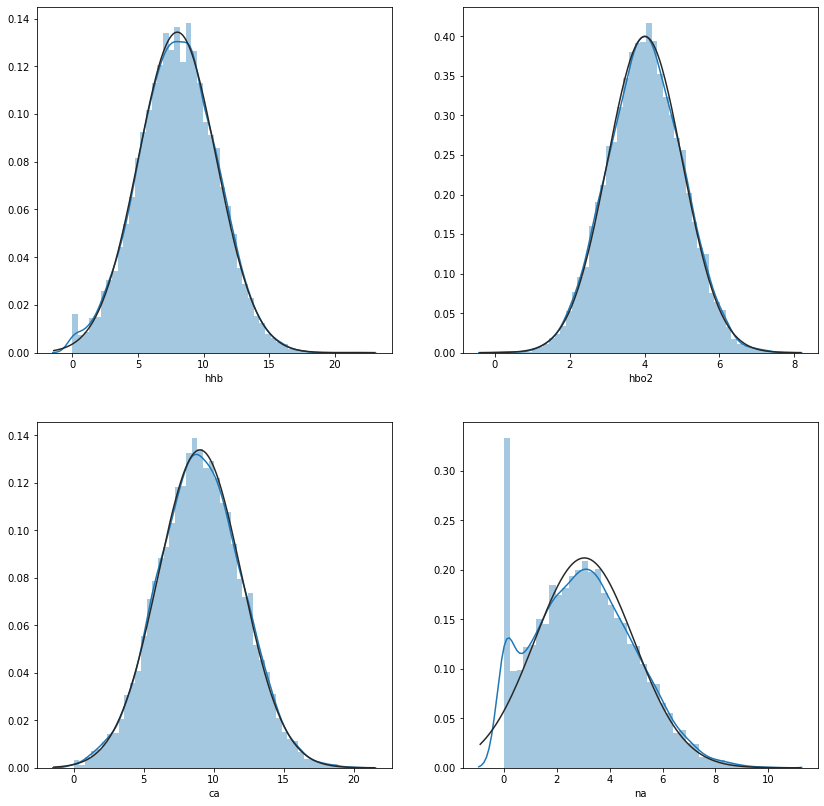

In [16]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14, 14)
sns.distplot(Ytrain['hhb'], ax=ax1, fit=norm)
sns.distplot(Ytrain['hbo2'], ax=ax2, fit=norm)
sns.distplot(Ytrain['ca'], ax=ax3, fit=norm)
sns.distplot(Ytrain['na'], ax=ax4, fit=norm)

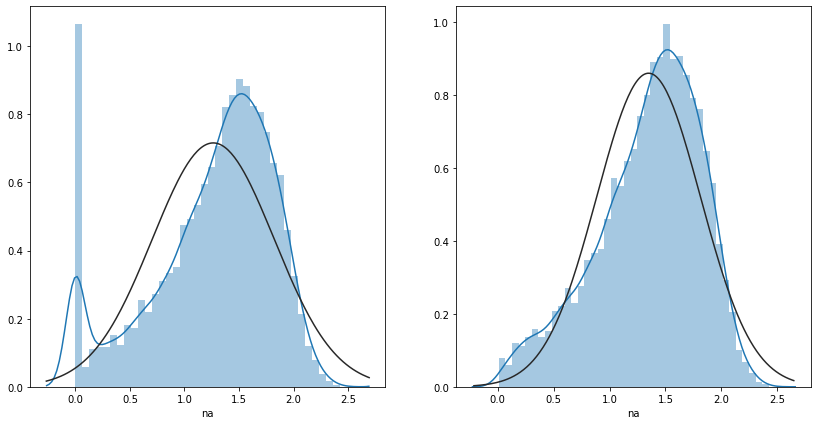

In [17]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14, 7)

sns.distplot(np.log(Ytrain['na']+1), fit=norm, ax=ax1)
sns.distplot(np.log(Ytrain.loc[Ytrain['na']!=0,'na']+1), fit=norm, ax=ax2)

## Normalize

In [18]:
normalizer=Normalizer()
dst_features=[]
gap_features=[]
ratio_features=[]
real_features=[]
imag_features=[]

for col in list(Xtrain):
    if col[-4:] == '_dst':
        dst_features.append(col)
    elif col[-4:] == 'atio':
        ratio_features.append(col)
    elif col[-4:] == '_gap':
        gap_features.append(col)
    elif col[-4:] == 'real':
        real_features.append(col)
    elif col[-4:] == 'imag':
        imag_features.append(col)
    else:
        pass
print(len(dst_features + gap_features + ratio_features + real_features + imag_features) +1 == len(list(Xtrain)))

all_data = pd.concat((Xtrain, Xtest))
all_data[dst_features] = normalizer.fit_transform(all_data[dst_features])
all_data[imag_features] = normalizer.fit_transform(all_data[imag_features])
all_data[real_features] = normalizer.fit_transform(all_data[real_features])
all_data[gap_features] = normalizer.fit_transform(all_data[gap_features])

True


In [19]:
Xtrain = all_data[:len(Ytrain)]
Xtest = all_data[len(Ytrain):]

print(Xtrain.shape, Ytrain.shape, Xtest.shape)

(10000, 176) (10000, 4) (10000, 176)


# Prepare Data

In [20]:
Xtrain1 = Xtrain.copy()
Xtrain2 = Xtrain.copy()
Xtrain3 = Xtrain.copy()
Xtrain4 = Xtrain.copy()

Xtest1 = Xtest.copy()
Xtest2 = Xtest.copy()
Xtest3 = Xtest.copy()
Xtest4 = Xtest.copy()

# Feature Selection

## Genetic Algorithm

In [21]:
def apply_chromosome(chromosome, x_train):
    df = x_train.copy()
    for col, apply in zip(x_train.columns, chromosome):
        if apply == 0:
            df = df.drop(columns=col)
    return df


def scoring(model, x_train, y_train):
    return -cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()


def make_chromosome_score(chromosome, model, x_train, y_train):
    data= apply_chromosome(chromosome, x_train)
    value = scoring(model, data, y_train)
    return value


def choose_chromosomes(chromosomes_list, scored_list, factor, num_choose):
    chromosome_pool = chromosomes_list.copy()
    score_list = scored_list.copy()
    
    chosen_chromosome=[]
    
    new_score_array=np.array(score_list) + np.random.normal(0, np.array(score_list).std() * factor, size=len(score_list))
    new_score_list = list(new_score_array)
    
    for i in range(num_choose):
        select_index = np.argmin(new_score_list)
        selected = chromosome_pool[select_index]
        del chromosome_pool[select_index]
        del new_score_list[select_index]
        
        new_score_array = np.array(new_score_list)
        
        chosen_chromosome.append(selected)
    return chosen_chromosome




def crossover(chromosome_list, score_list, next_pool_size, factor, num_choose):
    child_pool = []
    while len(child_pool) < next_pool_size:
        best_parents=choose_chromosomes(chromosome_list, score_list, factor=factor, num_choose=num_choose)
        parents = random.sample(best_parents, 2)
        mom = parents[0]
        dad = parents[1]
        inherit = np.round(np.random.uniform(low=0, high=1, size=len(mom)))
        child = []

        for dna, i in zip(inherit, range(len(inherit))):
            if dna==0:
                child.append(mom[i])
            else:
                child.append(dad[i])
        child_pool.append(child)
    return child_pool



def mutant(pool, mutation_rate, mutation_size):
    to_be_mutant = np.round(np.random.uniform(low=0, high=1, size=len(pool)) - (0.5 - mutation_rate))
    which_child = np.where(to_be_mutant==1)[0]
    for child_index in which_child:
        mutation_info = np.round(np.random.uniform(low=0, high=1, size=len(to_be_mutant))-(0.5-mutation_size))
        mutation_info = np.where(mutation_info ==1)[0]

        for is_mutated in mutation_info:

            if pool[child_index][is_mutated]==0:
                pool[child_index][is_mutated] = 1
            elif pool[child_index][is_mutated]==1:
                pool[child_index][is_mutated] = 0
    return pool


def next_generation(model, x_train, y_train, first_gen_chromosome, next_pool_size, factor, num_choose_parents, 
                   mutation_rate, mutation_size):
    score_list=[]
    for chromosome in tqdm(first_gen_chromosome):
        score = make_chromosome_score(chromosome, model, x_train, y_train)
        score_list.append(score)
    print("Calculating Current Generation's Score")
        
    current_generation_best_chromosome = first_gen_chromosome[np.argmin(score_list)]
    current_generation_best_score = np.min(score_list)
    current_generation_mean_score = np.mean(score_list)


    print(current_generation_best_chromosome)
    print(f"\nBest Score : {current_generation_best_score}")

    print("Generating Child pool")
    child_pool = crossover(first_gen_chromosome, score_list, next_pool_size=next_pool_size, 
                           factor=factor, num_choose=num_choose_parents)
    print("Generating Mutation childs")
    next_generation_chromosomes = mutant(child_pool, mutation_rate=mutation_rate, mutation_size=mutation_size)
    
    print('Done!')
    return next_generation_chromosomes, current_generation_best_chromosome, \
                current_generation_best_score, current_generation_mean_score





def feature_select_ga(model, x_train, y_train, num_epoch, pool_size, factor=0.1, 
                      num_choose_parents=3, mutation_rate=0.05, mutation_size=0.05, plot_score = True):
    
    #factor : percentage of noise added to calculated score
    #if too large, bad scoring parents could be selected since score order changes
    
    #mutation_rate : percentage of childs to be mutated
    #mutation_size : percentage of genes to be mutated
    
    pool_size = pool_size
    pool=[]
    
    for i in range(pool_size):
        chromosome = np.round(np.random.uniform(low=0, high=1, size=x_train.shape[1]))
        pool.append(chromosome)
    
    best_features=[]
    best_scores=[]
    mean_scores=[]
    
    for i in tqdm(range(num_epoch)):
        pool, gen_best_features, gen_best_score, gen_mean_score = next_generation(model, x_train, y_train, pool, 
                                                                            next_pool_size=pool_size, 
                                                                            factor = factor, 
                                                                            num_choose_parents=num_choose_parents, 
                                                                            mutation_rate=mutation_rate, 
                                                                            mutation_size=mutation_size)
        best_features.append(gen_best_features)
        best_scores.append(gen_best_score)
        mean_scores.append(gen_mean_score)
        
    
    final_score_list=[]
    for chromosome in tqdm(pool):
        score = make_chromosome_score(chromosome, base_model, x_train, y_train)
        final_score_list.append(score)

    last_generation_best_chromosome = pool[np.argmin(final_score_list)]
    last_generation_best_score = np.min(final_score_list)
    last_generation_mean_score = np.mean(final_score_list)

    best_features.append(last_generation_best_chromosome)
    best_scores.append(last_generation_best_score)
    mean_scores.append(last_generation_mean_score)
    
    if plot_score==True:
        figure, ax1 = plt.subplots(nrows=1, ncols=1)
        figure.set_size_inches(10, 7)
        sns.lineplot(data=np.array(best_scores), ax=ax1, label='best')
        sns.lineplot(data=np.array(mean_scores), ax=ax1, label='mean')
        
    best_chromosome = best_features[np.argmin(best_scores)]

    df = apply_chromosome(best_chromosome, x_train)
    print(f"best_features = {list(df)}")
    return df

변수 선택을 위해 유전 알고리즘 구현. 위에서 선언한 base_model 을 이용해서, 점수를 매기고, 최고의 점수를 내는 변수 조합을 선택. 

In [22]:
#Xtrain1 = feature_select_ga(base_model, Xtrain1, Ytrain1, pool_size=15, num_epoch=20,
#                           num_choose_parents=4, mutation_rate=0.1, mutation_size=0.1)
#Xtest1 = Xtest1[list(Xtrain1)]

best_features = ['rho', '650_dst', '680_dst', '770_dst', '790_dst', '810_dst', '830_dst', '840_dst', '850_dst', '860_dst', '880_dst', '890_dst', '930_dst', '960_dst', '980_dst', '650_dst_650_src_ratio', '660_dst_660_src_ratio', '690_dst_690_src_ratio', '720_dst_720_src_ratio', '760_dst_760_src_ratio', '770_dst_770_src_ratio', '800_dst_800_src_ratio', '810_dst_810_src_ratio', '830_dst_830_src_ratio', '840_dst_840_src_ratio', '850_dst_850_src_ratio', '860_dst_860_src_ratio', '870_dst_870_src_ratio', '920_dst_920_src_ratio', '930_dst_930_src_ratio', '940_dst_940_src_ratio', '990_dst_990_src_ratio', '650_gap', '700_gap', '720_gap', '790_gap', '800_gap', '820_gap', '840_gap', '860_gap', '910_gap', '920_gap', '930_gap', '940_gap', '950_gap', '960_gap', '980_gap', '660_dst_fft_real', '670_dst_fft_real', '680_dst_fft_real', '690_dst_fft_real', '720_dst_fft_real', '740_dst_fft_real', '780_dst_fft_real', '800_dst_fft_real', '810_dst_fft_real', '840_dst_fft_real', '850_dst_fft_real', '870_dst_fft_real', '890_dst_fft_real', '910_dst_fft_real', '920_dst_fft_real', '930_dst_fft_real', '950_dst_fft_real', '650_dst_fft_imag', '670_dst_fft_imag', '730_dst_fft_imag', '770_dst_fft_imag', '780_dst_fft_imag', '840_dst_fft_imag', '850_dst_fft_imag', '860_dst_fft_imag', '890_dst_fft_imag', '900_dst_fft_imag', '920_dst_fft_imag', '960_dst_fft_imag', '980_dst_fft_imag', '990_dst_fft_imag']
Xtrain1 = Xtrain1[best_features]
Xtest1 = Xtest1[best_features]


print(Xtrain1.shape, Ytrain1.shape, Xtest1.shape)

(10000, 78) (10000,) (10000, 78)


In [23]:
#Xtrain2 = feature_select_ga(base_model, Xtrain2, Ytrain2, pool_size=15, num_epoch=20, 
#                            num_choose_parents=4, mutation_rate=0.1, mutation_size=0.1)
#Xtest2 = Xtest2[list(Xtrain2)]

best_features = ['rho', '670_dst', '730_dst', '750_dst', '770_dst', '780_dst', '790_dst', '800_dst', '830_dst', '870_dst', '890_dst', '900_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst', '670_dst_670_src_ratio', '730_dst_730_src_ratio', '740_dst_740_src_ratio', '750_dst_750_src_ratio', '780_dst_780_src_ratio', '790_dst_790_src_ratio', '800_dst_800_src_ratio', '830_dst_830_src_ratio', '840_dst_840_src_ratio', '850_dst_850_src_ratio', '890_dst_890_src_ratio', '910_dst_910_src_ratio', '920_dst_920_src_ratio', '930_dst_930_src_ratio', '950_dst_950_src_ratio', '970_dst_970_src_ratio', '990_dst_990_src_ratio', '650_gap', '670_gap', '690_gap', '770_gap', '780_gap', '790_gap', '800_gap', '810_gap', '820_gap', '960_gap', '980_gap', '990_gap', '660_dst_fft_real', '670_dst_fft_real', '730_dst_fft_real', '750_dst_fft_real', '770_dst_fft_real', '800_dst_fft_real', '810_dst_fft_real', '830_dst_fft_real', '880_dst_fft_real', '930_dst_fft_real', '950_dst_fft_real', '960_dst_fft_real', '970_dst_fft_real', '980_dst_fft_real', '990_dst_fft_real', '650_dst_fft_imag', '670_dst_fft_imag', '680_dst_fft_imag', '700_dst_fft_imag', '720_dst_fft_imag', '730_dst_fft_imag', '740_dst_fft_imag', '750_dst_fft_imag', '780_dst_fft_imag', '790_dst_fft_imag', '840_dst_fft_imag', '850_dst_fft_imag', '860_dst_fft_imag', '870_dst_fft_imag', '880_dst_fft_imag', '920_dst_fft_imag', '930_dst_fft_imag', '940_dst_fft_imag', '950_dst_fft_imag', '960_dst_fft_imag']
Xtrain2 = Xtrain2[best_features]
Xtest2 = Xtest2[best_features]

print(Xtrain2.shape, Ytrain2.shape, Xtest2.shape)

(10000, 81) (10000,) (10000, 81)


In [24]:
#Xtrain3 = feature_select_ga(base_model, Xtrain3, Ytrain3, pool_size=15, num_epoch=20, 
#                           num_choose_parents=4, mutation_rate=0.1, mutation_size=0.1)
#Xtest3 = Xtest3[list(Xtrain3)]

best_features = ['rho', '670_dst', '680_dst', '700_dst', '750_dst', '760_dst', '780_dst', '800_dst', '810_dst', '820_dst', '840_dst', '850_dst', '860_dst', '880_dst', '910_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '650_dst_650_src_ratio', '670_dst_670_src_ratio', '690_dst_690_src_ratio', '710_dst_710_src_ratio', '720_dst_720_src_ratio', '740_dst_740_src_ratio', '750_dst_750_src_ratio', '770_dst_770_src_ratio', '830_dst_830_src_ratio', '840_dst_840_src_ratio', '850_dst_850_src_ratio', '860_dst_860_src_ratio', '870_dst_870_src_ratio', '900_dst_900_src_ratio', '950_dst_950_src_ratio', '960_dst_960_src_ratio', '980_dst_980_src_ratio', '680_gap', '690_gap', '740_gap', '760_gap', '770_gap', '790_gap', '800_gap', '820_gap', '830_gap', '840_gap', '860_gap', '870_gap', '890_gap', '910_gap', '920_gap', '940_gap', '960_gap', '980_gap', '990_gap', '710_dst_fft_real', '720_dst_fft_real', '730_dst_fft_real', '740_dst_fft_real', '750_dst_fft_real', '760_dst_fft_real', '770_dst_fft_real', '780_dst_fft_real', '810_dst_fft_real', '820_dst_fft_real', '830_dst_fft_real', '840_dst_fft_real', '850_dst_fft_real', '860_dst_fft_real', '870_dst_fft_real', '920_dst_fft_real', '930_dst_fft_real', '950_dst_fft_real', '970_dst_fft_real', '980_dst_fft_real', '660_dst_fft_imag', '670_dst_fft_imag', '690_dst_fft_imag', '720_dst_fft_imag', '730_dst_fft_imag', '740_dst_fft_imag', '750_dst_fft_imag', '770_dst_fft_imag', '780_dst_fft_imag', '790_dst_fft_imag', '800_dst_fft_imag', '810_dst_fft_imag', '830_dst_fft_imag', '860_dst_fft_imag', '880_dst_fft_imag', '890_dst_fft_imag', '930_dst_fft_imag', '940_dst_fft_imag', '950_dst_fft_imag', '960_dst_fft_imag', '980_dst_fft_imag']
Xtrain3 = Xtrain[best_features]
Xtest3 = Xtest[best_features]

print(Xtrain3.shape, Ytrain3.shape, Xtest3.shape)

(10000, 98) (10000,) (10000, 98)


In [25]:
#Xtrain4 = feature_select_ga(base_model, Xtrain4, Ytrain4, pool_size=15, num_epoch=20, 
#                           num_choose_parents=4, mutation_rate=0.1, mutation_size=0.1)
#Xtest4 = Xtest4[list(Xtrain4)]

best_features = ['rho', '670_dst', '680_dst', '690_dst', '720_dst', '740_dst', '750_dst', '760_dst', '780_dst', '790_dst', '830_dst', '840_dst', '850_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', '920_dst', '950_dst', '970_dst', '980_dst', '650_dst_650_src_ratio', '700_dst_700_src_ratio', '710_dst_710_src_ratio', '720_dst_720_src_ratio', '730_dst_730_src_ratio', '740_dst_740_src_ratio', '760_dst_760_src_ratio', '770_dst_770_src_ratio', '780_dst_780_src_ratio', '800_dst_800_src_ratio', '810_dst_810_src_ratio', '830_dst_830_src_ratio', '840_dst_840_src_ratio', '850_dst_850_src_ratio', '860_dst_860_src_ratio', '870_dst_870_src_ratio', '880_dst_880_src_ratio', '890_dst_890_src_ratio', '910_dst_910_src_ratio', '920_dst_920_src_ratio', '930_dst_930_src_ratio', '980_dst_980_src_ratio', '660_gap', '680_gap', '690_gap', '700_gap', '710_gap', '770_gap', '780_gap', '850_gap', '860_gap', '880_gap', '900_gap', '910_gap', '920_gap', '930_gap', '950_gap', '650_dst_fft_real', '670_dst_fft_real', '680_dst_fft_real', '690_dst_fft_real', '710_dst_fft_real', '720_dst_fft_real', '740_dst_fft_real', '760_dst_fft_real', '810_dst_fft_real', '840_dst_fft_real', '850_dst_fft_real', '860_dst_fft_real', '890_dst_fft_real', '900_dst_fft_real', '940_dst_fft_real', '970_dst_fft_real', '980_dst_fft_real', '660_dst_fft_imag', '670_dst_fft_imag', '710_dst_fft_imag', '720_dst_fft_imag', '730_dst_fft_imag', '770_dst_fft_imag', '780_dst_fft_imag', '790_dst_fft_imag', '810_dst_fft_imag', '870_dst_fft_imag', '890_dst_fft_imag', '910_dst_fft_imag', '940_dst_fft_imag', '950_dst_fft_imag', '970_dst_fft_imag']
Xtrain4 = Xtrain4[best_features]
Xtest4 = Xtest4[best_features]


print(Xtrain4.shape, Ytrain4.shape, Xtest4.shape)

(10000, 91) (10000,) (10000, 91)


'#' 을 지우고 변수 선택 코드를 진행하면, 950 * 20 * 4 / 3600 = 약 21.11  - 4개 데이터셋 변수 선택 약 21시간 걸림. best_features 에 진행했던 결과물들만 복사해서 4개의 다른 Xtrain 들을 만들었음.

# Build Models

## LightGBM

### hhb

In [26]:
lgb_params1 = {'n_estimators': 2785, 'learning_rate': 0.012256313719980687, 'num_leaves': 73, 
               'colsample_bytree': 0.6424334465587705, 'subsample': 0.6084147966276774, 
               'reg_alpha': 4.334078134974237e-05, 'reg_lambda': 0.00024427748977268426, 'min_data_in_leaf': 16}
lgb1 = LGBMRegressor(subsample_freq=1, silent=False, random_state=18, **lgb_params1)

lgb_score1 = model_scoring_cv(lgb1, Xtrain1, Ytrain1)
print(f"lgb score 1 : {lgb_score1}")

Validation Time : 312.063 sec
lgb score 1 : 0.6450181806462878


### hbo2

In [27]:
lgb_params2 = {'n_estimators': 2994, 'learning_rate': 0.02064007127149768, 'num_leaves': 36, 
               'colsample_bytree': 0.9662203993996966, 'subsample': 0.8235831321555162, 
               'reg_alpha': 9.361670014148117e-10, 'reg_lambda': 0.014778229454777763, 'min_data_in_leaf': 69}

lgb2=LGBMRegressor(subsample_freq=1, silent=False, random_state=18, **lgb_params2)
lgb_score2 = model_scoring_cv(lgb2, Xtrain2, Ytrain2)
print(f"lgb score 2 : {lgb_score2}")

Validation Time : 242.814 sec
lgb score 2 : 0.47096186669621254


### ca

In [28]:
lgb_params3 = {'n_estimators': 2351, 'learning_rate': 0.0142123934679665, 'num_leaves': 60, 
               'colsample_bytree': 0.8200484609355502, 'subsample': 0.8682071101415381, 
               'reg_alpha': 0.019504059762055263, 'reg_lambda': 6.760777234202785e-07, 'min_data_in_leaf': 58}

lgb3=LGBMRegressor(subsample_freq=1, silent=False, random_state=18, **lgb_params3)
lgb_score3 = model_scoring_cv(lgb3, Xtrain3, Ytrain3)
print(f"lgb score 3 : {lgb_score3}")

Validation Time : 301.473 sec
lgb score 3 : 1.519919905631499


### na

In [29]:
lgb_params4 = {'n_estimators': 2036, 'learning_rate': 0.010105984741650555, 'num_leaves': 262, 
               'colsample_bytree': 0.5481503221078929, 'subsample': 0.6283957235662508, 
               'reg_alpha': 1.3143634189790955e-06, 'reg_lambda': 1.4769566595629849e-05, 
               'min_data_in_leaf': 86}

lgb4=LGBMRegressor(subsample_freq=1, silent=False, random_state=18, **lgb_params4)
lgb_score4 = model_scoring_cv(lgb4, Xtrain4, Ytrain4)
print(f"lgb score 4 : {lgb_score4}")

Validation Time : 141.399 sec
lgb score 4 : 1.0987161424910443


In [30]:
print(f"LightGBM Mean CV Score : {(lgb_score1 + lgb_score2 + lgb_score3 + lgb_score4)/4}")

LightGBM Mean CV Score : 0.933654023866261


## XGBoost

### hhb

In [31]:
xgb_params1 = {'n_estimators': 2881, 'learning_rate': 0.011711857673636635, 'max_depth': 8, 
               'colsample_bytree': 0.9827808935047092, 
               'subsample': 0.5710690334832227, 'reg_alpha': 1.3854966003147966, 
               'reg_lambda': 0.0003816097499332342}

xgb1 = XGBRegressor(verbosity=0, random_state=18, objective = 'reg:squarederror', eval_metric='mae', 
                    **xgb_params1, 
                   sampling_method='gradient_based', tree_method='gpu_hist'
                   )

xgb_score1 = model_scoring_cv(xgb1, Xtrain1, Ytrain1)
print(f"xgb score 1 : {xgb_score1}")

Validation Time : 974.623 sec
xgb score 1 : 0.6597893721626996


### hbo2

In [32]:
xgb_params2 = {'n_estimators': 2865, 'learning_rate': 0.043801989516317016, 'max_depth': 4, 
               'colsample_bytree': 0.8778900801725762, 'subsample': 0.7274550283257443, 
               'reg_alpha': 2.792469294881351e-07, 'reg_lambda': 18.480038009887284}

xgb2 = XGBRegressor(verbosity=0, random_state=18, objective = 'reg:squarederror', eval_metric='mae', 
                    **xgb_params2, 
                   sampling_method='gradient_based', tree_method='gpu_hist', 
                   )

xgb_score2 = model_scoring_cv(xgb2, Xtrain2, Ytrain2)
print(f"xgb score 2 : {xgb_score2}")

Validation Time : 232.204 sec
xgb score 2 : 0.4805120802893638


### ca

In [33]:
xgb_params3 = {'n_estimators': 2643, 'learning_rate': 0.031712179695614046, 'max_depth': 5, 
               'colsample_bytree': 0.7424966681183006, 'subsample': 0.787669908095534, 
               'reg_alpha': 0.0019021769478904957, 'reg_lambda': 0.6331937967083731}

xgb3 = XGBRegressor(verbosity=0, random_state=18, objective = 'reg:squarederror', eval_metric='mae', 
                    **xgb_params3,
                    sampling_method='gradient_based', tree_method='gpu_hist', 
                   )

xgb_score3 = model_scoring_cv(xgb3, Xtrain3, Ytrain3)
print(f"xgb score 3 : {xgb_score3}")

Validation Time : 315.204 sec
xgb score 3 : 1.5351869589180944


### na

In [34]:
xgb_params4 = {'n_estimators': 2692, 'learning_rate': 0.0304561991789567, 'max_depth': 6, 
               'colsample_bytree': 0.561225558419653, 'subsample': 0.7109372329820719, 
               'reg_alpha': 6.551680601955312e-08, 'reg_lambda': 4.484664174506758}

xgb4 = XGBRegressor(verbosity=0, random_state=18, objective = 'reg:squarederror', eval_metric='mae', 
                    **xgb_params4, 
                   sampling_method='gradient_based', tree_method='gpu_hist', 
                   )


xgb_score4 = model_scoring_cv(xgb4, Xtrain4, Ytrain4)
print(f"xgb score 4 : {xgb_score4}")

Validation Time : 426.062 sec
xgb score 4 : 1.107904721993923


In [35]:
print(f"XGBoost Mean CV Score : {(xgb_score1 + xgb_score2 + xgb_score3 + xgb_score4)/4}")

XGBoost Mean CV Score : 0.9458482833410202


## CatBoost

### hhb

In [36]:
cat_params1 = {'iterations': 2681, 'depth': 7, 'learning_rate': 0.08663866615470771, 
               'random_strength': 9.235074797628041, 'l2_leaf_reg': 8.164833371246262, 
               'bagging_temperature': 0.8220097439681222}

cat1 = CatBoostRegressor(loss_function='MAE', random_seed=18, verbose=False, **cat_params1,
                         task_type='GPU'
                        )
cat_score1 = model_scoring_cv(cat1, Xtrain1, Ytrain1)
print(f"CatBoostScore1 : {cat_score1}")

Validation Time : 785.542 sec
CatBoostScore1 : 0.6847231512252785


### hbo2

In [37]:
cat_params2 = {'iterations': 2769, 'depth': 6, 'learning_rate': 0.17889638008330497, 
               'random_strength': 9.283130620824029, 'l2_leaf_reg': 43.78952651533997, 
               'bagging_temperature': 0.7378285753465266}
cat2 = CatBoostRegressor(loss_function='MAE', random_seed=18, verbose=False, **cat_params2,
                         task_type='GPU'
                        )
cat_score2 = model_scoring_cv(cat2, Xtrain2, Ytrain2)
print(f"CatBoostScore2 : {cat_score2}")

Validation Time : 609.407 sec
CatBoostScore2 : 0.4901726900123041


### ca

In [38]:
cat_params3 = {'iterations': 2843, 'depth': 7, 'learning_rate': 0.2677960942055296, 
               'random_strength': 5.280805075485188, 'l2_leaf_reg': 6.178243639724696, 
               'bagging_temperature': 0.03590951004104092}

cat3 = CatBoostRegressor(loss_function='MAE', random_seed=18, verbose=False, **cat_params3,
                         task_type='GPU'
                        )
cat_score3 = model_scoring_cv(cat3, Xtrain3, Ytrain3)
print(f"CatBoostScore3 : {cat_score3}")

Validation Time : 938.061 sec
CatBoostScore3 : 1.5602005106402956


### na

In [39]:
cat_params4 = {'iterations': 2911, 'depth': 7, 'learning_rate': 0.0923974192869855, 
               'bagging_temperature': 0.04030601548502897, 'random_strength': 8.50411971804888}

cat4 = CatBoostRegressor(loss_function='MAE', random_seed=18, verbose=False, **cat_params4,
                         task_type='GPU'
                        )
cat_score4 = model_scoring_cv(cat4, Xtrain4, Ytrain4)
print(f"CatBoostScore4 : {cat_score4}")

Validation Time : 899.926 sec
CatBoostScore4 : 1.1108542319122767


In [40]:
print(f"CatBoost Mean CV Score : {(cat_score1 + cat_score2 + cat_score3 + cat_score4) / 4}")

CatBoost Mean CV Score : 0.9614876459475388


# Ensemble

In [41]:
models_hhb=[lgb1, xgb1, cat1]
models_hbo2=[lgb2, xgb2, cat2]
models_ca=[lgb3, xgb3, cat3]
models_na=[lgb4, xgb4, cat4]

In [42]:
train_preds_hhb = pd.DataFrame(data=None, index=train.index)
train_preds_hbo2 = pd.DataFrame(data=None, index=train.index)
train_preds_ca = pd.DataFrame(data=None, index=train.index)
train_preds_na = pd.DataFrame(data=None, index=train.index)

test_preds_hhb = pd.DataFrame(data=None, index=test.index)
test_preds_hbo2 = pd.DataFrame(data=None, index=test.index)
test_preds_ca = pd.DataFrame(data=None, index=test.index)
test_preds_na = pd.DataFrame(data=None, index=test.index)

In [43]:
for bag_train, bag_test, x, y, xtest, models in zip(
                                [train_preds_hhb, train_preds_hbo2, train_preds_ca, train_preds_na], 
                                [test_preds_hhb, test_preds_hbo2, test_preds_ca, test_preds_na], 
                                [Xtrain1, Xtrain2, Xtrain3, Xtrain4],
                                [Ytrain1, Ytrain2, Ytrain3, Ytrain4], 
                                [Xtest1, Xtest2, Xtest3, Xtest4],
                                [models_hhb, models_hbo2, models_ca, models_na]):

    for model, names in tqdm(zip(models, ['lgb', 'cat', 'xgb'])):
        bag_train[f"{names}_{i}"] = cross_val_predict(model, x, y, cv=5)
        model.fit(x, y)
        bag_test[f"{names}_{i}"] = model.predict(xtest)
        
print(train_preds_hhb.shape, train_preds_hbo2.shape, train_preds_ca.shape, train_preds_na.shape)
print(test_preds_hhb.shape, test_preds_hbo2.shape, test_preds_ca.shape, test_preds_na.shape)

2it [15:12, 406.93s/it]Warning: less than 75% gpu memory available for training. Free: 4450.2 Total: 6144
3it [22:56, 458.98s/it]
2it [06:35, 222.33s/it]Warning: less than 75% gpu memory available for training. Free: 3819.0125 Total: 6144
3it [12:35, 251.73s/it]
2it [08:35, 286.84s/it]Warning: less than 75% gpu memory available for training. Free: 3044.45 Total: 6144
3it [17:54, 358.18s/it]
2it [06:33, 175.54s/it]Warning: less than 75% gpu memory available for training. Free: 2323.1375 Total: 6144
3it [15:26, 308.87s/it]


(10000, 3) (10000, 3) (10000, 3) (10000, 3)
(10000, 3) (10000, 3) (10000, 3) (10000, 3)


튜닝한 LightGBM, XGBoost, CatBoost 를 ExtraTreesRegressor 로 스태킹, 최종 결과물 만들기.

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
et1_params = {} #I lost my hyperparameter after training... :(
et2_params = {'n_estimators': 84, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 1}
et3_params = {'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 161, 'min_samples_leaf': 1}
et4_params = {'n_estimators': 83, 'max_depth': 6, 'min_samples_split': 158, 'min_samples_leaf': 1}


et1 = ExtraTreesRegressor(**et1_params)
et2 = ExtraTreesRegressor(**et2_params)
et3 = ExtraTreesRegressor(**et3_params)
et4 = ExtraTreesRegressor(**et4_params)

ets_list=[et1, et2, et3, et4]

mean_score = 0
for model, x, y, xtest in zip(ets_list, 
                       [train_preds_hhb, train_preds_hbo2, train_preds_ca, train_preds_na], 
                       [Ytrain1, Ytrain2, Ytrain3, Ytrain4], 
                       [test_preds_hhb, test_preds_hbo2, test_preds_ca, test_preds_na]):
    mean_score = mean_score + model_scoring_cv(model, x, y, n_jobs=1)
    model.fit(x, y)
    pred = model.predict(xtest)
    submission[y.name] = pred
    
print(f"Mean CV Score : {mean_score / 4}")
submission.head()

In [53]:
submission.to_csv('Final ETS Ensemble CV 0_93309.csv')